<a href="https://colab.research.google.com/github/WendyGalvisL/repo-api-starter/blob/master/Prueba_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importar librerías

In [46]:
pip install optuna

In [47]:
!pip install scikeras

In [48]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

# Cargar datos

In [49]:
df = pd.read_csv('train_data.csv')
df.head()

,ID,Bankruptcy,Realized.Sales.Gross.Profit.Growth.Rate,Operating.Expense.Rate,Operating.Profit.Per.Share..Yuan...,Gross.Profit.to.Sales,Tax.rate..A.,Current.Liability.to.Liability,Continuous.Net.Profit.Growth.Rate,Long.term.Liability.to.Current.Assets,...,Per.Share.Net.profit.before.tax..Yuan...,Continuous.interest.rate..after.tax.,Liability.Assets.Flag,Working.Capital.to.Total.Assets,Degree.of.Financial.Leverage..DFL.,Operating.Gross.Margin,Contingent.liabilities.Net.worth,Operating.Profit.Growth.Rate,Cash.Flow.to.Liability,Quick.Assets.Total.Assets
0,1,0,0.087661,1.900349e-04,0.131094,0.583345,0.000000,0.815892,0.395719,0.089276,...,0.223720,0.801737,0,0.839112,0.036551,0.591350,0.007401,0.913175,0.489822,0.138714
1,2,0,0.021892,5.371576e-04,0.086167,0.695478,0.209649,0.768636,0.163505,0.000000,...,0.324763,0.791203,0,0.908450,0.126752,0.766066,0.020514,0.849241,0.550247,0.704211
2,3,0,0.102249,2.178329e-04,0.157755,0.766934,0.272061,0.643316,0.181571,0.010180,...,0.360892,0.803126,0,0.865943,0.018152,0.687211,0.004363,0.865814,0.447168,0.398086
3,4,0,0.029972,4.915756e+10,0.249279,0.611580,0.288357,0.752782,0.409196,0.018603,...,0.152445,0.824732,0,0.806254,0.051284,0.715973,0.014162,0.843357,0.485163,0.617386
4,6,0,0.021164,1.206001e-04,0.239817,0.614250,0.000000,0.559498,0.286989,0.148687,...,0.217282,0.787010,0,0.769843,0.012872,0.704043,0.003050,0.884905,0.422001,0.187121


In [50]:
df.shape

(2050, 65)

In [51]:
# Eliminar columna ID
df = df.drop(columns='ID')

# Explorar datos

In [52]:
print('Number of duplicated', df.duplicated().sum())
print('Number of nan', df.isnull().sum().sum())

Number of duplicated 0
Number of nan 0


In [53]:
# Dividir datos
X = df.drop('Bankruptcy', axis=1)
y = df['Bankruptcy']

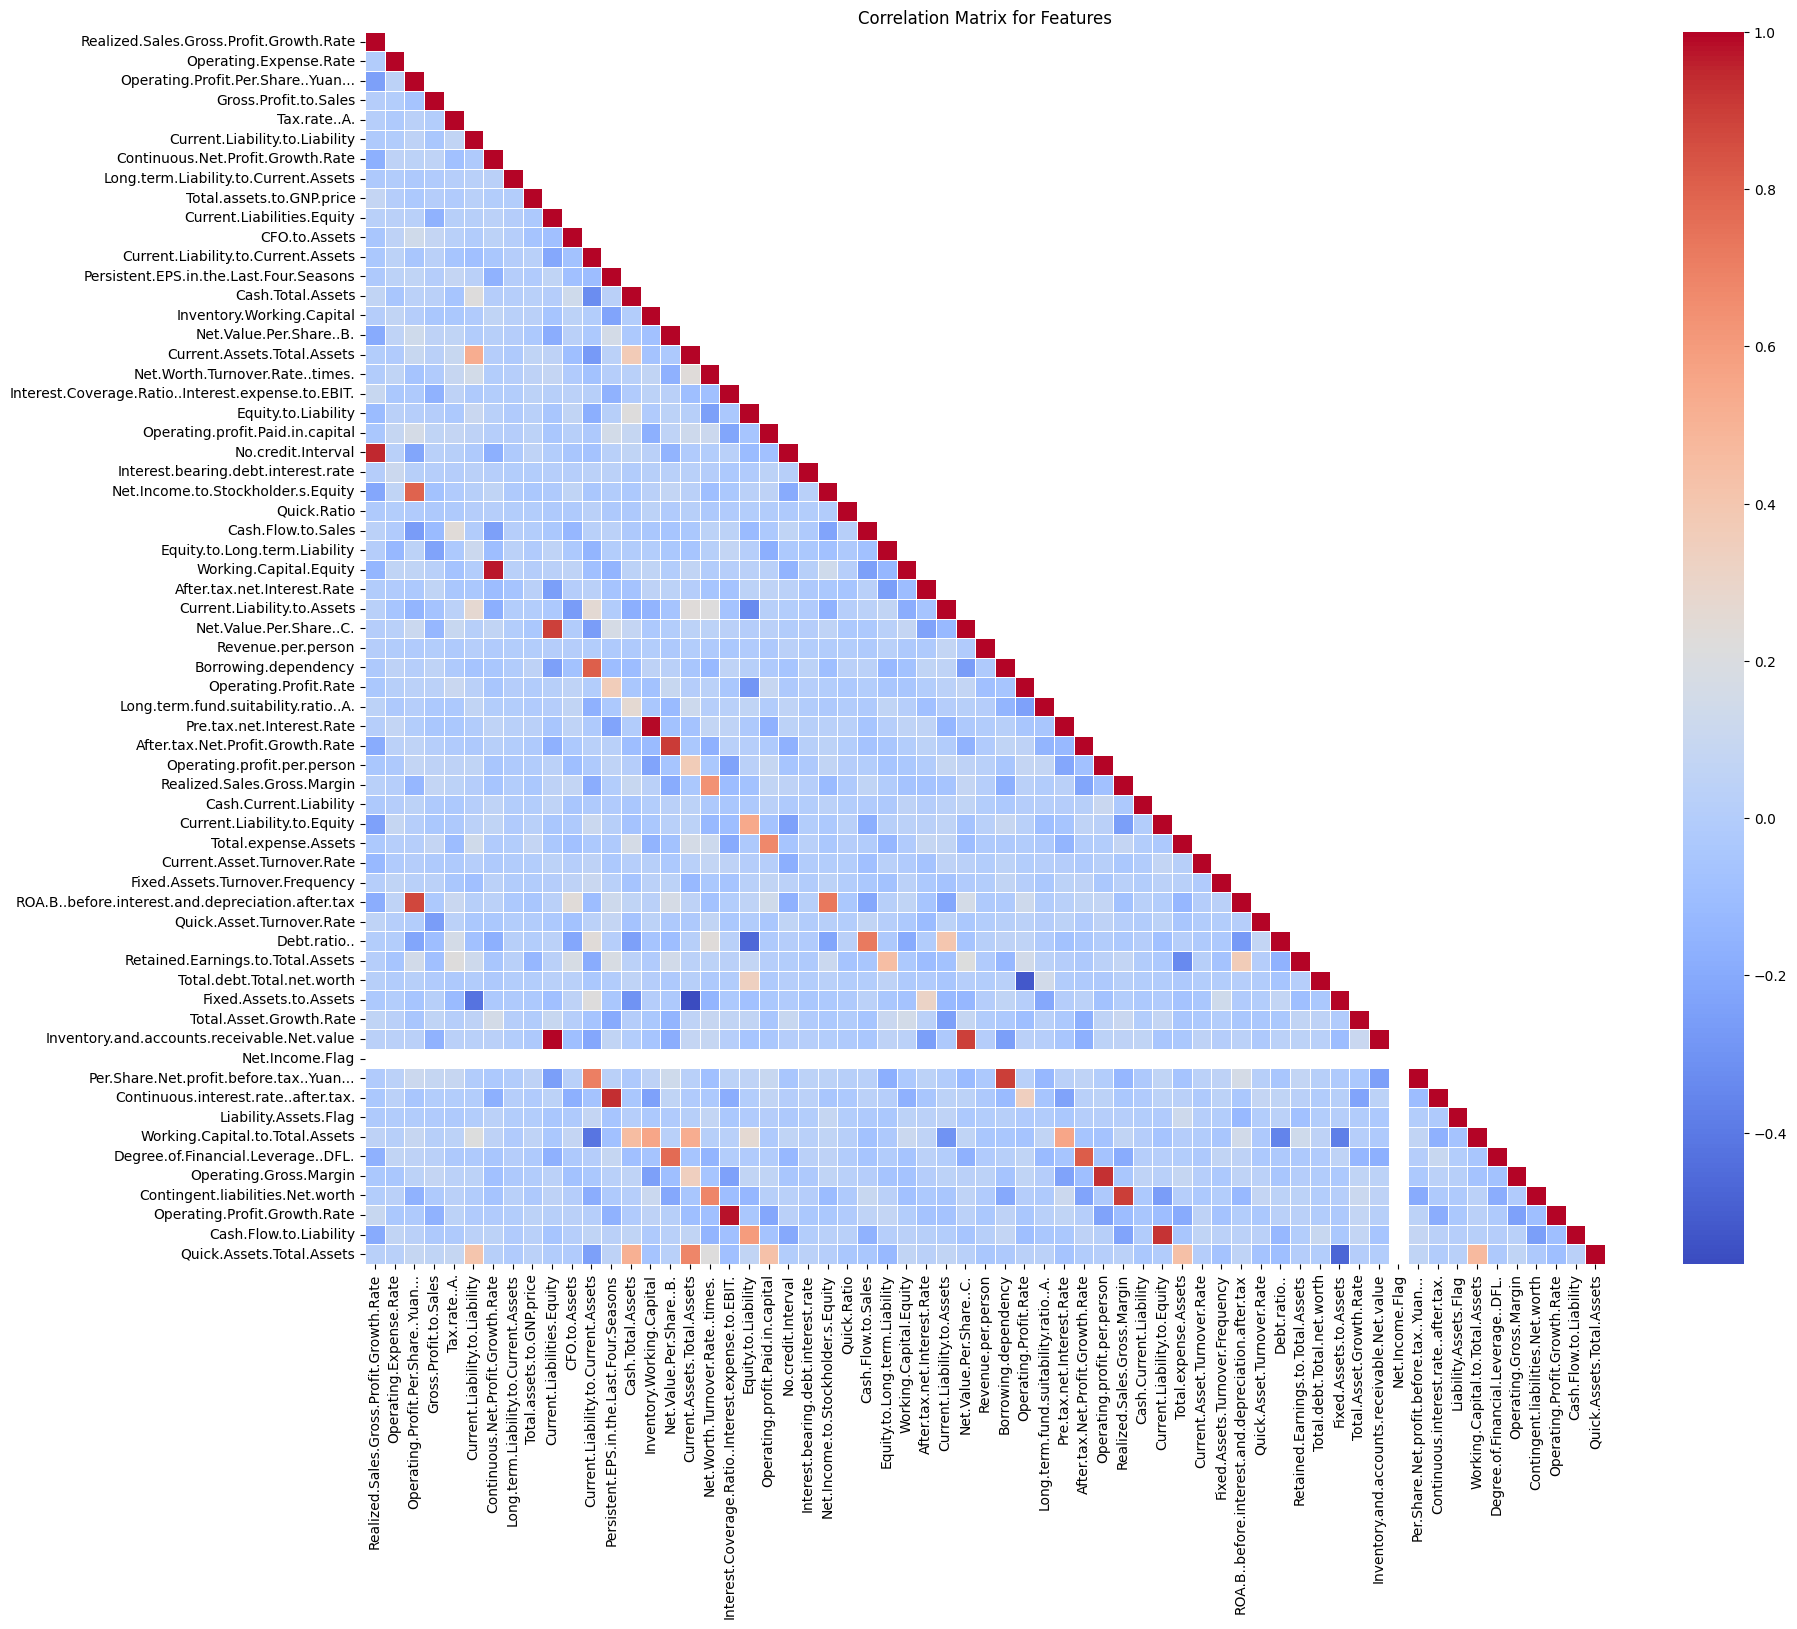

In [54]:
def display_correlation_matrix(corr_matrix):
    plt.figure(figsize=(20, 16))  # Adjust the size as needed
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5, mask=np.triu(corr_matrix, k=1))
    plt.title('Correlation Matrix for Features')
    plt.show()

corr_matrix = X.corr()
display_correlation_matrix(corr_matrix)

In [55]:
# Revisar variables con mayor y menor correlación
corr_matrix = X.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Extract the upper triangle values as a series
upper_tri_series = corr_matrix.where(mask).stack()
# Exclude values of 1
upper_tri_series = upper_tri_series[upper_tri_series != 1]
print("Top 10 positive correlations:")
print(upper_tri_series.abs().sort_values(ascending=False).head(10))
print("\nTop 10 negative correlations:")
print(upper_tri_series.abs().sort_values(ascending=False).tail(10).sort_values(ascending=True))

Top 10 positive correlations:
Current.Liabilities.Equity                          Inventory.and.accounts.receivable.Net.value    0.996549
Inventory.Working.Capital                           Pre.tax.net.Interest.Rate                      0.993849
Interest.Coverage.Ratio..Interest.expense.to.EBIT.  Operating.Profit.Growth.Rate                   0.979566
Continuous.Net.Profit.Growth.Rate                   Working.Capital.Equity                         0.970267
Realized.Sales.Gross.Profit.Growth.Rate             No.credit.Interval                             0.945186
Persistent.EPS.in.the.Last.Four.Seasons             Continuous.interest.rate..after.tax.           0.934840
Operating.profit.per.person                         Operating.Gross.Margin                         0.928718
Current.Liability.to.Equity                         Cash.Flow.to.Liability                         0.921697
Net.Value.Per.Share..B.                             After.tax.Net.Profit.Growth.Rate               0.90533

In [56]:
# Eliminar variables altamente correlacionadas
def remove_highly_correlated_features(corr_matrix, threshold=0.9):
    # Create a boolean mask for the upper triangle of the correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    return to_drop

features_to_drop = remove_highly_correlated_features(corr_matrix, threshold=0.9)

print(f"Features to drop: {features_to_drop}")

X = X.drop(features_to_drop, axis=1)

print(f"New shape of X: {X.shape}")

Features to drop: ['No.credit.Interval', 'Working.Capital.Equity', 'Pre.tax.net.Interest.Rate', 'After.tax.Net.Profit.Growth.Rate', 'Inventory.and.accounts.receivable.Net.value', 'Continuous.interest.rate..after.tax.', 'Operating.Gross.Margin', 'Operating.Profit.Growth.Rate', 'Cash.Flow.to.Liability']
New shape of X: (2050, 54)


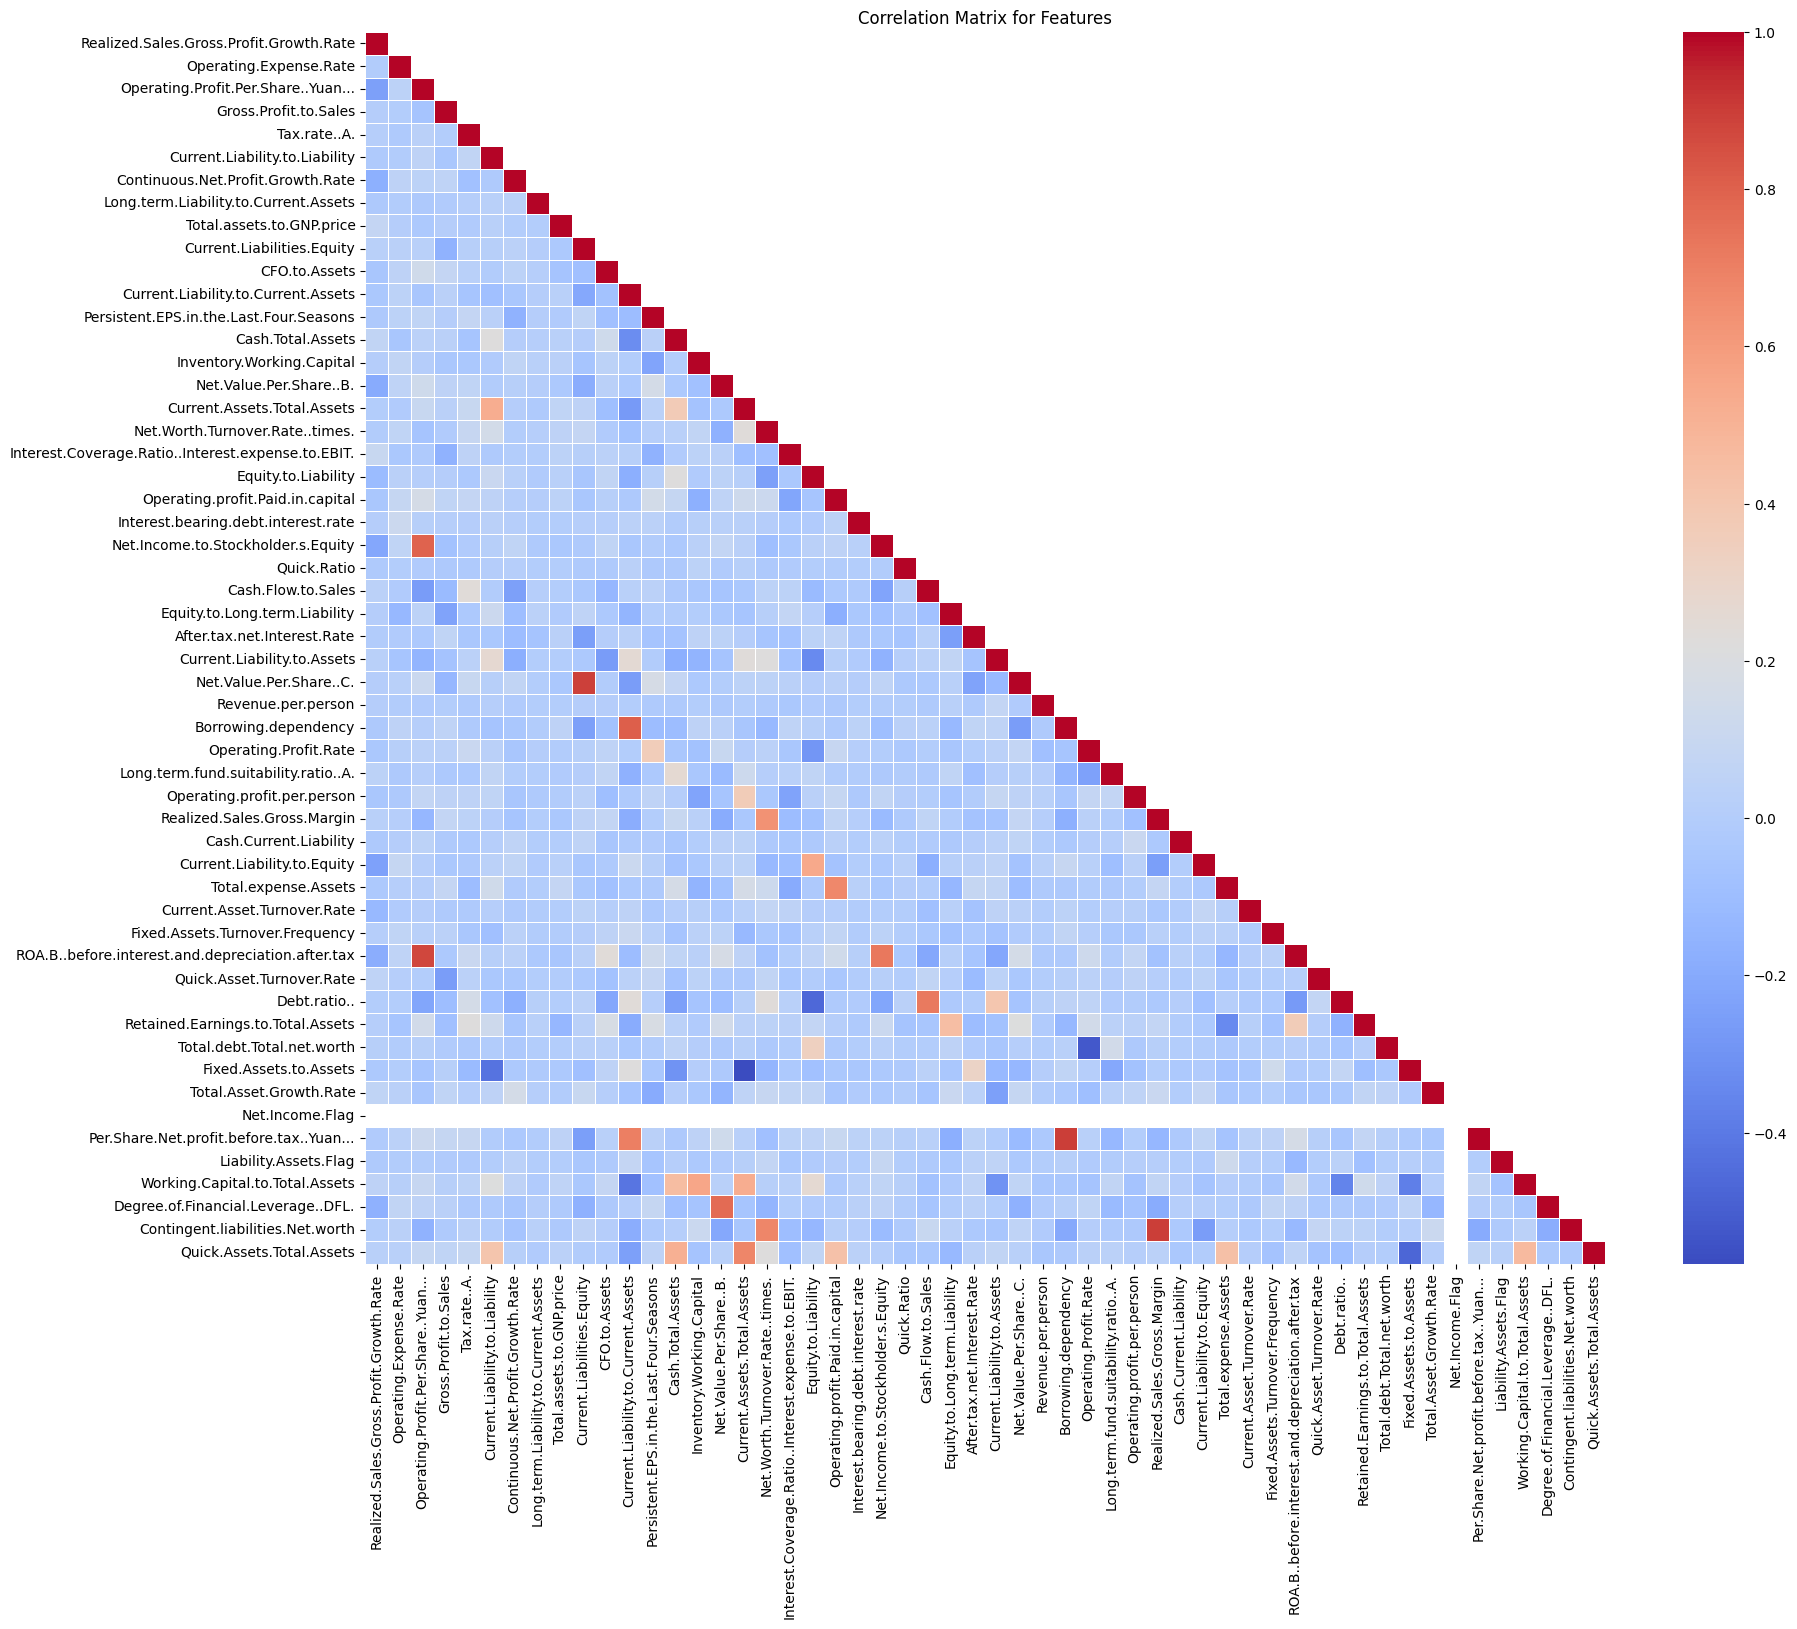

In [57]:
# Revisar nuevas correlaciones
corr_matrix = X.corr()
display_correlation_matrix(corr_matrix)

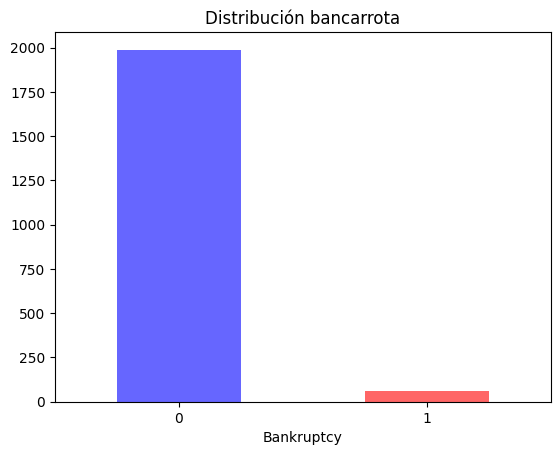

Compañías en bancarrota 62
Compañías que no cayeron en bancarrota 1988
Ratio de compañías en bancarrota 0.03118712273641851


In [58]:
y.value_counts().plot(kind='bar', title='Distribución bancarrota', color=['blue', 'red'], alpha=0.6, rot=0)
plt.show()
print('Compañías en bancarrota', y.value_counts()[1])
print('Compañías que no cayeron en bancarrota', y.value_counts()[0])
print('Ratio de compañías en bancarrota', y.value_counts()[1] / y.value_counts()[0])

En la gráfica anterior se puede observar que los datos están muy sesgados hacia las empresas que no están en quiebra.
Esto podría generar un mayor sesgo, prediciendo con mayor frecuencia la clase mayoritaria, lo cual puede generar una alta precisión, pero un bajo poder predictivo para la clase minoritaria.

Para corregir lo anterior, más adelante se buscará balancear un poco la clase minoritaria.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train set:', len(X_train), len(X_train) / len(X_train) + len(X_test))
print('Test set:', len(X_test), len(X_test) / len(X_train) + len(X_test))

Train set: 1640 411.0
Test set: 410 410.25


Ahora, para balancear las clases se usará SMOTE, que sirve para crear nuevas muestras de la clase minoritaria para que el modelo no se sesgue hacia la clase mayoritaria. Esto se hará únicamente para el set de entrenamiento.

In [60]:
print('Antes', y_train.value_counts())
print('Ratio de compañías en bancarrota:', y_train.value_counts()[1] / y_train.value_counts()[0])

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print('SMOTE train set:', y_train_smote.value_counts())
print('Ratio de compañías en bancarrota:', y_train_smote.value_counts()[1] / y_train_smote.value_counts()[0])

Antes Bankruptcy
0    1595
1      45
Name: count, dtype: int64
Ratio de compañías en bancarrota: 0.02821316614420063
SMOTE train set: Bankruptcy
0    1595
1    1595
Name: count, dtype: int64
Ratio de compañías en bancarrota: 1.0


In [61]:
# Estandarizar X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)

X_test_scaled = scaler.transform(X_test)

## Análisis de componentes proncipales

Se usará PCA para reducir la dimensionalidad en los datos

In [62]:
pca = PCA(n_components=0.90) # retener el 90% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


number_of_components = pca.n_components_
print('Número de componentes:', number_of_components)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)

Número de componentes: 30


A continuación, se muestra la varianza acumulada explicada por los componentes

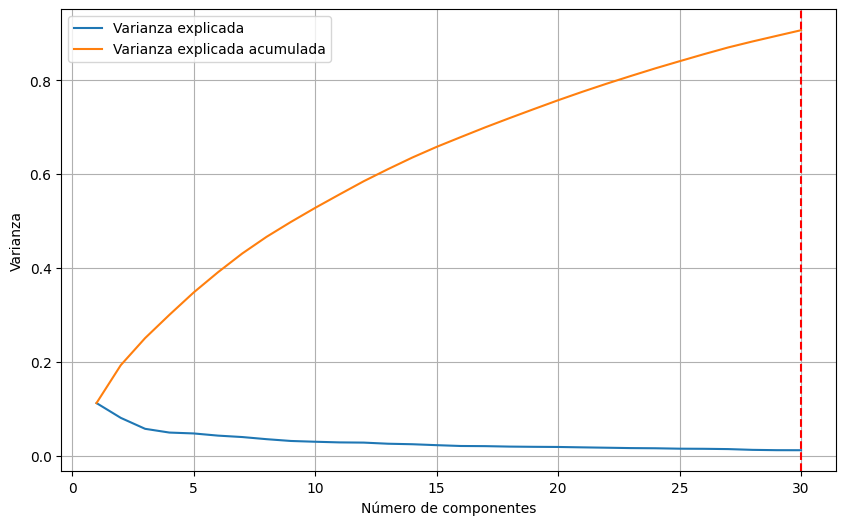

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, label='Varianza explicada')
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio,
            label='Varianza explicada acumulada')
plt.axvline(number_of_components, color='red', linestyle='--')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza')
plt.legend()
plt.grid()

# Red neuronal simple

In [64]:
def create_model(hidden_layers=(100, 100), activation='relu', learning_rate=0.001, dropout_rate=0.0):
    model = Sequential()

    # Capa de entrada + primera capa oculta
    model.add(Dense(hidden_layers[0], input_shape=(X_train_pca.shape[1],), activation=activation))

    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # Capas ocultas adicionales si hay más de una
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation=activation))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['AUC'])

    return model


In [65]:
keras_simple_model = create_model(hidden_layers=(10, 10, 10), activation='tanh', learning_rate=0.01)

keras_simple_model.fit(X_train_pca, y_train_smote, epochs=50, batch_size=32, verbose=1)

loss, accuracy = keras_simple_model.evaluate(X_test_pca, y_test, verbose=0)
print('Simple Keras Model Test Accuracy:', accuracy)

from sklearn.metrics import roc_auc_score
y_pred_proba_keras = keras_simple_model.predict(X_test_pca).ravel()
auc_score_keras = roc_auc_score(y_test, y_pred_proba_keras)
print('AUC en el conjunto de prueba:', auc_score_keras)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - AUC: 0.8695 - loss: 0.4191
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - AUC: 0.9812 - loss: 0.1498
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9891 - loss: 0.1146
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9933 - loss: 0.0779
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9954 - loss: 0.0632
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9945 - loss: 0.0629
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9972 - loss: 0.0370
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.9979 - loss: 0.0402
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.9964 - loss: 0.0426
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - AUC: 0.9951 - loss: 0.0597
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - AUC: 0.9977 - loss: 0.0324
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - AUC: 0.9984 - loss: 0.0283
Epoch 13/50
100/100 ━━

## Calibrar parámetros

In [66]:
import optuna
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score

def create_model(trial):
    model = keras.Sequential()

    # Hiperparámetros
    n_layers = trial.suggest_int("n_layers", 1, 3)
    input_dim = X_train_pca.shape[1]

    for i in range(n_layers):
        num_hidden = trial.suggest_int(f"n_units_l{i}", 16, 256)
        activation = trial.suggest_categorical(f"activation_l{i}", ["relu", "tanh", "sigmoid", "softmax" ])
        if i == 0:
            model.add(layers.Dense(num_hidden, activation=activation, input_dim=input_dim))
        else:
            model.add(layers.Dense(num_hidden, activation=activation))
        model.add(layers.Dropout(trial.suggest_float(f"dropout_l{i}", 0.1, 0.5)))

    model.add(layers.Dense(1, activation="sigmoid"))

    optimizer = trial.suggest_categorical("optimizer", ["adam", "rmsprop", "sgd"])
    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["AUC"]
    )

    return model

def objective(trial):
    model = create_model(trial)

    history = model.fit(
        X_train_pca, y_train_smote,
        validation_split=0.2,
        epochs=50,
        batch_size=trial.suggest_categorical("batch_size", [16, 32, 64]),
        verbose=0,
        callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
    )

    # Evaluar en el test (o validación interna)
    y_pred_prob = model.predict(X_test_pca).ravel()
    auc = roc_auc_score(y_test, y_pred_prob)
    return auc

# Crear y ejecutar el estudio
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
print("Mejores parámetros:", study.best_params)

[I 2025-04-20 02:06:52,747] A new study created in memory with name: no-name-9c4381c5-d931-4c9c-97e4-393c598f92f2


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-04-20 02:07:10,197] Trial 0 finished with value: 0.6899416255051638 and parameters: {'n_layers': 3, 'n_units_l0': 173, 'activation_l0': 'relu', 'dropout_l0': 0.24340922362572828, 'n_units_l1': 46, 'activation_l1': 'relu', 'dropout_l1': 0.4721985652463382, 'n_units_l2': 96, 'activation_l2': 'softmax', 'dropout_l2': 0.2157924367368701, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 0 with value: 0.6899416255051638.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-20 02:07:16,194] Trial 1 finished with value: 0.8934291273761412 and parameters: {'n_layers': 1, 'n_units_l0': 193, 'activation_l0': 'sigmoid', 'dropout_l0': 0.252403319096586, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 1 with value: 0.8934291273761412.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-20 02:07:25,867] Trial 2 finished with value: 0.8937284837599161 and parameters: {'n_layers': 3, 'n_units_l0': 212, 'activation_l0': 'sigmoid', 'dropout_l0': 0.4650186488780944, 'n_units_l1': 144, 'activation_l1': 'softmax', 'dropout_l1': 0.17426248904268044, 'n_units_l2': 245, 'activation_l2': 'tanh', 'dropout_l2': 0.10297704386362519, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 2 with value: 0.8937284837599161.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-20 02:07:58,426] Trial 3 finished with value: 0.7873072893279449 and parameters: {'n_layers': 1, 'n_units_l0': 95, 'activation_l0': 'softmax', 'dropout_l0': 0.14737436292635553, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 2 with value: 0.8937284837599161.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-20 02:08:03,223] Trial 4 finished with value: 0.8509205208801077 and parameters: {'n_layers': 2, 'n_units_l0': 87, 'activation_l0': 'tanh', 'dropout_l0': 0.45930157974809194, 'n_units_l1': 219, 'activation_l1': 'softmax', 'dropout_l1': 0.39396804433900445, 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 2 with value: 0.8937284837599161.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-20 02:08:18,718] Trial 5 finished with value: 0.8413411165993115 and parameters: {'n_layers': 2, 'n_units_l0': 210, 'activation_l0': 'softmax', 'dropout_l0': 0.25007540911828385, 'n_units_l1': 189, 'activation_l1': 'tanh', 'dropout_l1': 0.4978627982938738, 'optimizer': 'adam', 'batch_size': 32}. Best is trial 2 with value: 0.8937284837599161.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-20 02:08:22,344] Trial 6 finished with value: 0.36955545577009424 and parameters: {'n_layers': 3, 'n_units_l0': 48, 'activation_l0': 'sigmoid', 'dropout_l0': 0.35470477141443424, 'n_units_l1': 62, 'activation_l1': 'softmax', 'dropout_l1': 0.24836166331355158, 'n_units_l2': 124, 'activation_l2': 'sigmoid', 'dropout_l2': 0.4804074026634976, 'optimizer': 'sgd', 'batch_size': 64}. Best is trial 2 with value: 0.8937284837599161.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-20 02:08:42,154] Trial 7 finished with value: 0.7599161802125429 and parameters: {'n_layers': 1, 'n_units_l0': 35, 'activation_l0': 'softmax', 'dropout_l0': 0.19445122394047942, 'optimizer': 'rmsprop', 'batch_size': 32}. Best is trial 2 with value: 0.8937284837599161.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-20 02:09:17,708] Trial 8 finished with value: 0.851668911839545 and parameters: {'n_layers': 2, 'n_units_l0': 207, 'activation_l0': 'softmax', 'dropout_l0': 0.3343767229475206, 'n_units_l1': 69, 'activation_l1': 'sigmoid', 'dropout_l1': 0.22832397402371774, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 2 with value: 0.8937284837599161.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-20 02:09:24,147] Trial 9 finished with value: 0.894027840143691 and parameters: {'n_layers': 1, 'n_units_l0': 217, 'activation_l0': 'sigmoid', 'dropout_l0': 0.3463082523827915, 'optimizer': 'rmsprop', 'batch_size': 16}. Best is trial 9 with value: 0.894027840143691.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-20 02:09:45,905] Trial 10 finished with value: 0.8967220475976652 and parameters: {'n_layers': 1, 'n_units_l0': 255, 'activation_l0': 'tanh', 'dropout_l0': 0.38885102721302583, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 10 with value: 0.8967220475976652.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-04-20 02:10:06,562] Trial 11 finished with value: 0.8985181859003143 and parameters: {'n_layers': 1, 'n_units_l0': 255, 'activation_l0': 'tanh', 'dropout_l0': 0.39095164109138175, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 11 with value: 0.8985181859003143.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-20 02:10:22,494] Trial 12 finished with value: 0.8952252656787907 and parameters: {'n_layers': 1, 'n_units_l0': 248, 'activation_l0': 'tanh', 'dropout_l0': 0.40761063963987104, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 11 with value: 0.8985181859003143.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-20 02:10:38,172] Trial 13 finished with value: 0.8989672204759765 and parameters: {'n_layers': 1, 'n_units_l0': 251, 'activation_l0': 'tanh', 'dropout_l0': 0.4034920984015016, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 13 with value: 0.8989672204759765.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-20 02:11:13,311] Trial 14 finished with value: 0.8989672204759767 and parameters: {'n_layers': 2, 'n_units_l0': 145, 'activation_l0': 'tanh', 'dropout_l0': 0.4210694277177083, 'n_units_l1': 247, 'activation_l1': 'tanh', 'dropout_l1': 0.12564433402288452, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 14 with value: 0.8989672204759767.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-20 02:11:49,150] Trial 15 finished with value: 0.9034575662325999 and parameters: {'n_layers': 2, 'n_units_l0': 147, 'activation_l0': 'tanh', 'dropout_l0': 0.4973754104538815, 'n_units_l1': 256, 'activation_l1': 'tanh', 'dropout_l1': 0.10192896444240959, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-20 02:12:24,405] Trial 16 finished with value: 0.8842987576710073 and parameters: {'n_layers': 2, 'n_units_l0': 142, 'activation_l0': 'relu', 'dropout_l0': 0.4980501384075132, 'n_units_l1': 254, 'activation_l1': 'tanh', 'dropout_l1': 0.10473412962505718, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


[I 2025-04-20 02:12:59,023] Trial 17 finished with value: 0.8970214039814398 and parameters: {'n_layers': 2, 'n_units_l0': 140, 'activation_l0': 'tanh', 'dropout_l0': 0.45094271381725765, 'n_units_l1': 254, 'activation_l1': 'tanh', 'dropout_l1': 0.11013646286438666, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-20 02:13:28,462] Trial 18 finished with value: 0.891932345457267 and parameters: {'n_layers': 2, 'n_units_l0': 108, 'activation_l0': 'tanh', 'dropout_l0': 0.48995898915370273, 'n_units_l1': 189, 'activation_l1': 'tanh', 'dropout_l1': 0.17532537377930454, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-20 02:13:48,782] Trial 19 finished with value: 0.87067804220925 and parameters: {'n_layers': 3, 'n_units_l0': 154, 'activation_l0': 'tanh', 'dropout_l0': 0.4381566599723633, 'n_units_l1': 137, 'activation_l1': 'tanh', 'dropout_l1': 0.3337414432336551, 'n_units_l2': 20, 'activation_l2': 'relu', 'dropout_l2': 0.49935998537447845, 'optimizer': 'sgd', 'batch_size': 32}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-20 02:14:22,460] Trial 20 finished with value: 0.8741206406226613 and parameters: {'n_layers': 2, 'n_units_l0': 120, 'activation_l0': 'relu', 'dropout_l0': 0.31235048775502006, 'n_units_l1': 210, 'activation_l1': 'relu', 'dropout_l1': 0.1567380702200793, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


[I 2025-04-20 02:14:35,584] Trial 21 finished with value: 0.8661876964526269 and parameters: {'n_layers': 2, 'n_units_l0': 67, 'activation_l0': 'tanh', 'dropout_l0': 0.4224063275383471, 'n_units_l1': 229, 'activation_l1': 'sigmoid', 'dropout_l1': 0.2822973322612441, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-20 02:15:01,518] Trial 22 finished with value: 0.8950755874869032 and parameters: {'n_layers': 2, 'n_units_l0': 165, 'activation_l0': 'tanh', 'dropout_l0': 0.4997302922433639, 'n_units_l1': 97, 'activation_l1': 'tanh', 'dropout_l1': 0.10174522975609149, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


[I 2025-04-20 02:15:46,096] Trial 23 finished with value: 0.8670857656039515 and parameters: {'n_layers': 3, 'n_units_l0': 185, 'activation_l0': 'tanh', 'dropout_l0': 0.37213971999487516, 'n_units_l1': 179, 'activation_l1': 'tanh', 'dropout_l1': 0.2100264205664768, 'n_units_l2': 253, 'activation_l2': 'relu', 'dropout_l2': 0.34860262089139216, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-20 02:16:39,497] Trial 24 finished with value: 0.8976201167489897 and parameters: {'n_layers': 1, 'n_units_l0': 117, 'activation_l0': 'tanh', 'dropout_l0': 0.42374336102154275, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-20 02:17:13,108] Trial 25 finished with value: 0.8964226912138901 and parameters: {'n_layers': 2, 'n_units_l0': 227, 'activation_l0': 'tanh', 'dropout_l0': 0.28881806582309005, 'n_units_l1': 159, 'activation_l1': 'tanh', 'dropout_l1': 0.342137652604365, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-20 02:17:39,912] Trial 26 finished with value: 0.8989672204759767 and parameters: {'n_layers': 2, 'n_units_l0': 71, 'activation_l0': 'tanh', 'dropout_l0': 0.47257467446092016, 'n_units_l1': 105, 'activation_l1': 'sigmoid', 'dropout_l1': 0.1546774122295865, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-20 02:18:10,354] Trial 27 finished with value: 0.8908845981140547 and parameters: {'n_layers': 2, 'n_units_l0': 19, 'activation_l0': 'tanh', 'dropout_l0': 0.4648189143182401, 'n_units_l1': 104, 'activation_l1': 'sigmoid', 'dropout_l1': 0.14813781621043273, 'optimizer': 'sgd', 'batch_size': 16}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


[I 2025-04-20 02:18:24,465] Trial 28 finished with value: 0.8477772788504715 and parameters: {'n_layers': 2, 'n_units_l0': 72, 'activation_l0': 'relu', 'dropout_l0': 0.10794469679326074, 'n_units_l1': 106, 'activation_l1': 'sigmoid', 'dropout_l1': 0.14834297226376766, 'optimizer': 'adam', 'batch_size': 64}. Best is trial 15 with value: 0.9034575662325999.


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


[I 2025-04-20 02:18:49,393] Trial 29 finished with value: 0.903158209848825 and parameters: {'n_layers': 3, 'n_units_l0': 168, 'activation_l0': 'relu', 'dropout_l0': 0.47463812902605856, 'n_units_l1': 17, 'activation_l1': 'sigmoid', 'dropout_l1': 0.18863964710139747, 'n_units_l2': 184, 'activation_l2': 'tanh', 'dropout_l2': 0.3274108634627951, 'optimizer': 'sgd', 'batch_size': 32}. Best is trial 15 with value: 0.9034575662325999.


Mejores parámetros: {'n_layers': 2, 'n_units_l0': 147, 'activation_l0': 'tanh', 'dropout_l0': 0.4973754104538815, 'n_units_l1': 256, 'activation_l1': 'tanh', 'dropout_l1': 0.10192896444240959, 'optimizer': 'sgd', 'batch_size': 16}


In [67]:
# Usar los mejores parámetros encontrados por Optuna
best_params = study.best_params

# Construimos el modelo final con los mejores parámetros
def build_best_model(params):
    model = keras.Sequential()
    input_dim = X_train_pca.shape[1]

    for i in range(params['n_layers']):
        model.add(layers.Dense(params[f'n_units_l{i}'], activation=params[f'activation_l{i}'],
                               input_dim=input_dim if i == 0 else None))
        model.add(layers.Dropout(params[f'dropout_l{i}']))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=params['optimizer'],
        loss='binary_crossentropy',
        metrics=['AUC']
    )

    return model

final_model = build_best_model(best_params)

# Entrenar con TODO el set de entrenamiento balanceado
final_model.fit(X_train_pca, y_train_smote, epochs=50, batch_size=best_params['batch_size'],
                verbose=1, callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.7814 - loss: 0.5434
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9485 - loss: 0.2946
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9588 - loss: 0.2558
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9545 - loss: 0.2688
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9670 - loss: 0.2256
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9598 - loss: 0.2497
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9662 - loss: 0.2273
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9639 - loss: 0.2352
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9648 - loss: 0.2299
Epoch 10/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.9698 - loss: 0.2118
Epoch 11/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9634 - loss: 0.2305
Epoch 12/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - AUC: 0.9671 - loss: 0.2228
Epoch 13/50
200/200 ━━━━━

In [68]:
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas por el modelo en el conjunto de prueba
y_pred_prob = final_model.predict(X_test_pca).ravel()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [69]:
# Calcular AUC
auc_score = roc_auc_score(y_test, y_pred_prob)

# Mostrar el resultado
print(f"AUC en el conjunto de prueba: {auc_score:.4f}")

AUC en el conjunto de prueba: 0.8951


In [77]:
# Calcular AUC
auc_score = roc_auc_score(y_test, y_pred_prob)

# Mostrar el resultado
print(f"AUC en el conjunto de prueba: {auc_score:.4f}")

AUC en el conjunto de prueba: 0.8951


# Predicciones

In [71]:
df_test_pred =pd.read_csv("test_data.csv", index_col=0)

In [72]:
# Eliminamos las mismas columnas que se eliminaron en el conjunto de entrenamiento
df_test_pred = df_test_pred.drop(columns=features_to_drop)

In [73]:
# Escalar los datos (usando el mismo scaler que se usó para X_train)
X_test_sc = scaler.transform(df_test_pred)

In [74]:
# Aplicar la misma transformación PCA al conjunto de test
X_test_final = pca.transform(X_test_sc)

In [80]:
y_pred_prob = final_model.predict(X_test_final).ravel()
y_pred_class = (y_pred_prob >= 0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [81]:
predicciones = pd.DataFrame({
    'ID': df_test_pred.index,
    'Bankruptcy': y_pred_class
})

In [82]:
predicciones.set_index('ID', inplace=True)
predicciones.to_csv('predicciones.csv')

print(predicciones.head())

    Bankruptcy
ID            
5            0
14           1
16           0
26           1
28           0
